In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ec = pd.read_parquet('../data/processed/reddit_btc_wsbelite_relevant_posts_with_sentiment.parquet')
yc = pd.read_parquet('../data/processed/reddit_relevant_posts_with_sentiment_yc.parquet')
jl = pd.read_parquet('../data/processed/reddit_relevant_posts_with_sentiment.parquet')
jc = pd.read_parquet('../data/processed/bitcoinBeginners_BitcoinMining_reddit_relevant_posts_with_sentiment.parquet')
print('jl', jl.columns)
print('ec', ec.columns)

#rm 'iso_year', 'iso_week' from jl
jl = jl.drop(columns=['iso_year', 'iso_week'])
df = pd.concat([ec, yc, jl, jc], ignore_index=True)

jl Index(['post_id', 'title', 'body', 'author', 'upvotes', 'downvotes', 'score',
       'num_comments', 'url', 'created_at', 'subreddit', 'date_created',
       'is_relevant', 'year', 'week', 'day', 'iso_year', 'iso_week',
       'top_comments', 'overall_sentiment', 'sentiment_score'],
      dtype='object')
ec Index(['post_id', 'title', 'body', 'author', 'upvotes', 'downvotes', 'score',
       'num_comments', 'url', 'created_at', 'subreddit', 'date_created',
       'is_relevant', 'year', 'week', 'day', 'top_comments',
       'overall_sentiment', 'sentiment_score'],
      dtype='object')


## EDA

below we can see that aggregating over the 10 most active bitcoin related subreddits, the post density becomes a lot less sparse. in fact, comparing against BTC daily trading volume, we see roughly a similar shape, with a lull in activity in Q3. so less of a concern with regards to completeness of reddit data that we can model our sentiment with.

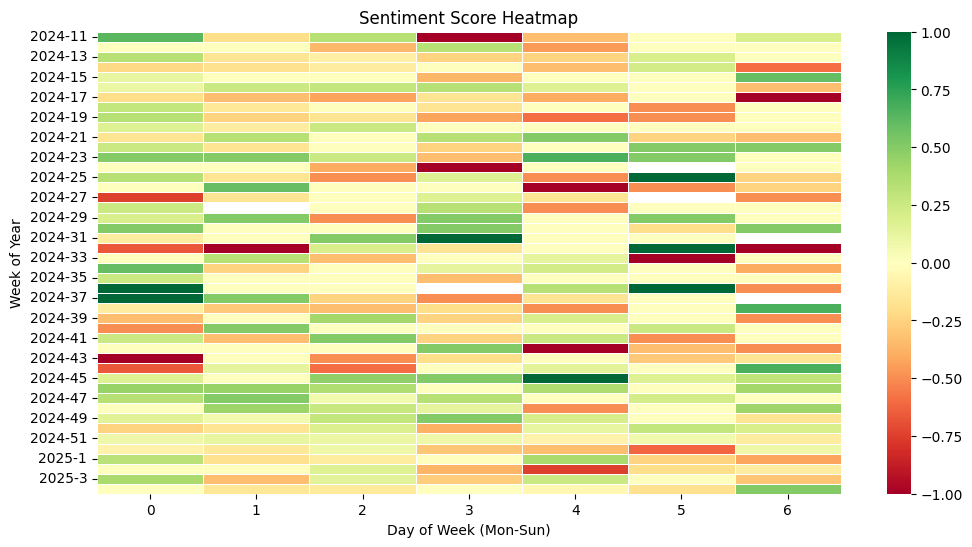

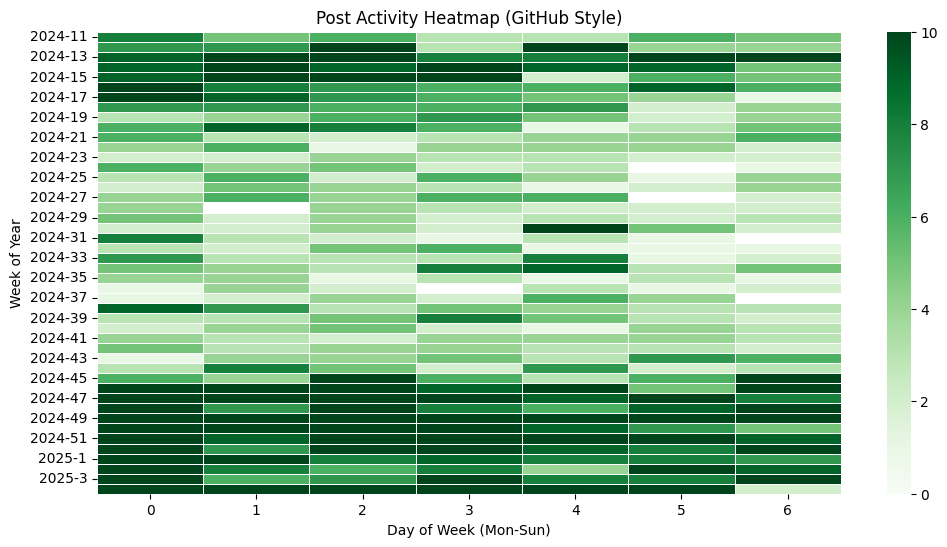

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_14496/820456992.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volume['datetime'] = pd.to_datetime(volume['datetime'])


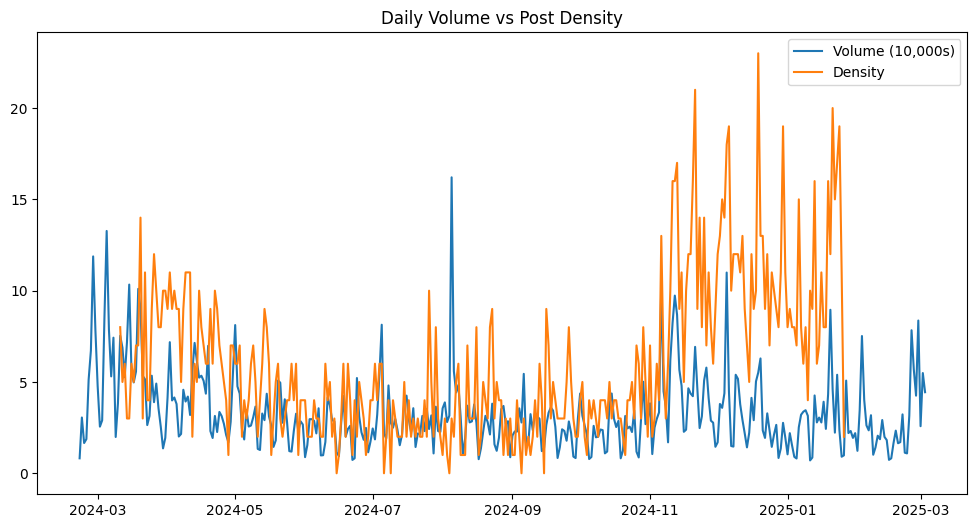

In [2]:
heatmap_data = df.groupby(['year', 'week', 'day']).size().unstack()
heatmap_data_2 = df.groupby(["year", "week", "day"])["sentiment_score"].mean().unstack()
plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data_2, cmap="RdYlGn", linewidths=0.5, linecolor="white", center=0, vmin=-1, vmax=1)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Sentiment Score Heatmap")
plt.show()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="Greens", linewidths=0.5, linecolor="white", vmin=0, vmax=10)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Post Activity Heatmap (GitHub Style)")

plt.show()


btc = pd.read_csv("../data/processed/btc_usdt_hourly_processed.csv")
volume = btc[['datetime', 'VOLUME']]
#daily volume
volume['datetime'] = pd.to_datetime(volume['datetime'])
volume = volume.set_index('datetime')
volume = volume.resample('D').sum()

#df daily post density
df['date_created'] = pd.to_datetime(df['date_created'])
df = df.set_index('date_created')
density = df.resample('D').size()

plt.figure(figsize=(12, 6))
plt.plot(volume /10000, label='Volume (10,000s)')
plt.plot(density , label='Density')
plt.legend()
plt.title('Daily Volume vs Post Density')
plt.show()




/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_14496/22239851.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time = df['created_at'].min().floor('H')
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_14496/22239851.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_time = df['created_at'].max().ceil('H')
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_14496/22239851.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                           smoothed_sentiment
2024-03-11 12:00:00+00:00            0.000000
2024-03-11 13:00:00+00:00            0.966562
2024-03-11 14:00:00+00:00            1.924711
2024-03-11 15:00:00+00:00            1.841377
2024-03-11 16:00:00+00:00            2.717604


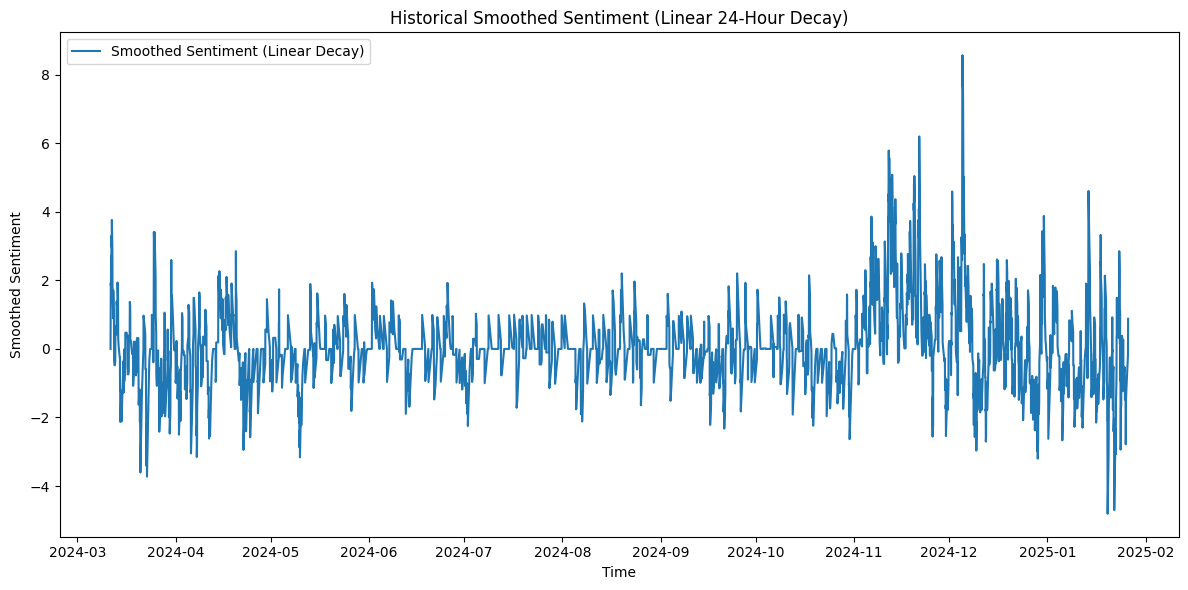

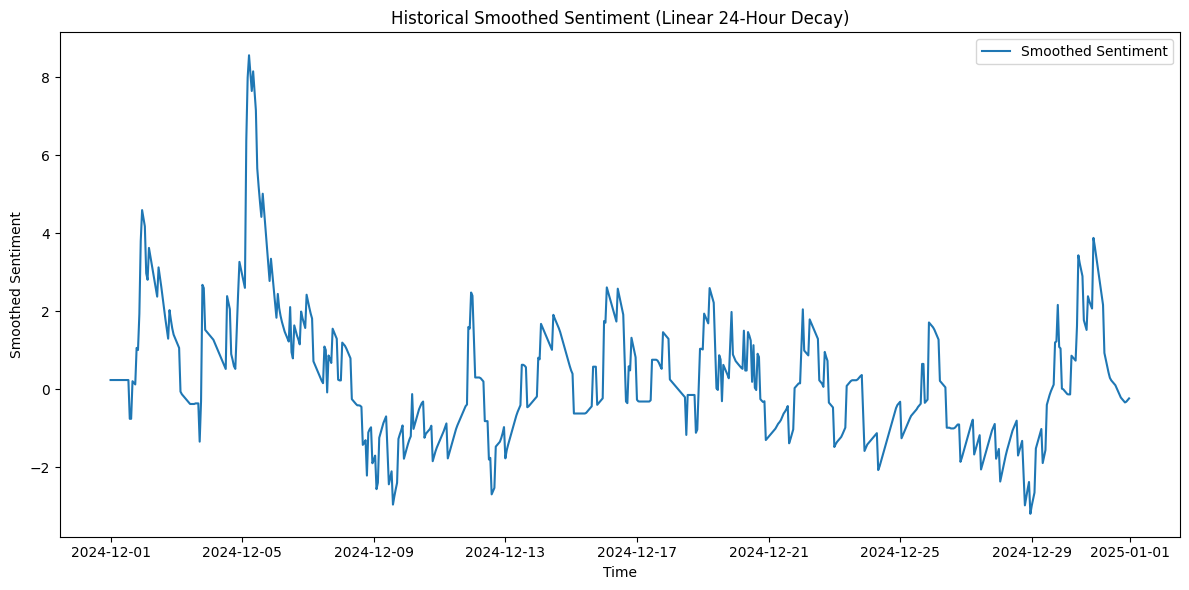

In [3]:
df['created_at'] = pd.to_datetime(df['created_at'])

# Define the start and end time for the analysis (rounded to the nearest hour)
start_time = df['created_at'].min().floor('H')
end_time = df['created_at'].max().ceil('H')

# Create an hourly date range
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_linear(t):
    """
    Compute the smoothed sentiment at time t as the weighted sum of sentiment scores
    in the past 24 hours. Each news event decays linearly: its weight is 
    1 - (time difference in hours)/24.
    """
    # Define the 24-hour window for events affecting time t
    window_start = t - pd.Timedelta(hours=24)
    
    # Filter news events that occurred in the last 24 hours (excluding events after t)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    
    if df_window.empty:
        return 0.0  # No news, no sentiment effect.
    
    # Calculate the time difference (in hours) between t and each news event
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Linear decay: weight = 1 - (difference/24)
    weights = 1 - (time_diffs / 24)
    weights = weights.clip(lower=0)  # Ensure no negative weights
    
    # Compute the weighted sentiment sum
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# Apply the function to each timestamp in the hourly index
smoothed_sentiments = [compute_smoothed_sentiment_linear(t) for t in hourly_index]

# Create a DataFrame with the results
df_sentiment = pd.DataFrame({'smoothed_sentiment': smoothed_sentiments}, index=hourly_index)

# Display the first few rows
print(df_sentiment.head())

# Optionally, plot the smoothed sentiment time series 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment'], label='Smoothed Sentiment (Linear Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment'], label='Smoothed Sentiment')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_14496/4097292014.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                           smoothed_sentiment  smoothed_sentiment_weibull
2024-03-11 12:00:00+00:00            0.000000                    0.000000
2024-03-11 13:00:00+00:00            0.966562                    0.306328
2024-03-11 14:00:00+00:00            1.924711                    0.641744
2024-03-11 15:00:00+00:00            1.841377                    1.255152
2024-03-11 16:00:00+00:00            2.717604                    2.053003


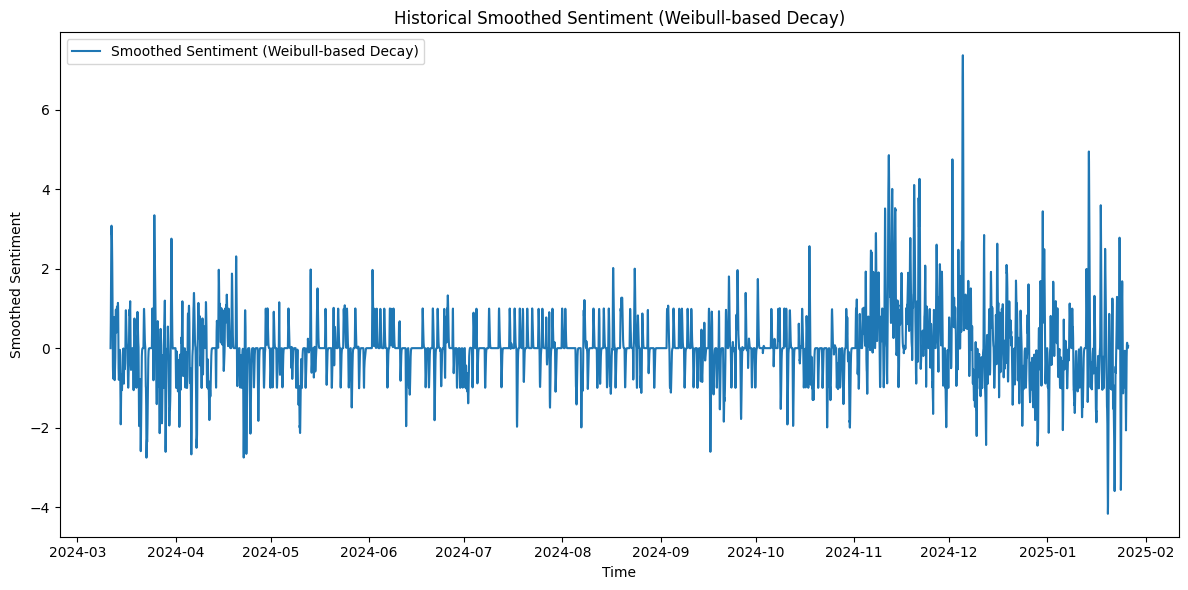

In [4]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt


# Parameters for the Weibull distribution
k = 2.0       # shape parameter (k > 1 gives a peak)
lam = 6.0     # scale parameter in hours (peak attention around ~4.24 hours)
# Determine the mode (peak) of the Weibull PDF and compute its maximum value
x_mode = lam * ((k - 1) / k) ** (1 / k)
max_weight = weibull_min.pdf(x_mode, k, scale=lam)

def weight_function(x):
    """Compute the weight for elapsed time x (in hours) using the Weibull PDF normalized to 1."""
    if x < 0:
        return 0.0
    return weibull_min.pdf(x, k, scale=lam) / max_weight

# Create an hourly date range for the smoothed sentiment time series
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_weibull(t):
    """
    Compute the smoothed sentiment at time t by summing the weighted sentiment scores
    from news events in the last 48 hours.
    """
    # Consider news events from the past 48 hours
    window_start = t - pd.Timedelta(hours=48)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    if df_window.empty:
        return 0.0
    # Compute elapsed time in hours from each news event to time t
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Calculate weights for each news event using the Weibull function
    weights = time_diffs.apply(weight_function)
    # Compute the weighted sum of sentiment scores
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# Compute the smoothed sentiment for each hour in the time series
smoothed_sentiments = [compute_smoothed_sentiment_weibull(t) for t in hourly_index]
df_sentiment['smoothed_sentiment_weibull'] = smoothed_sentiments

# Display the first few rows
print(df_sentiment.head())

# Plot the smoothed sentiment over time
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull'], label='Smoothed Sentiment (Weibull-based Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

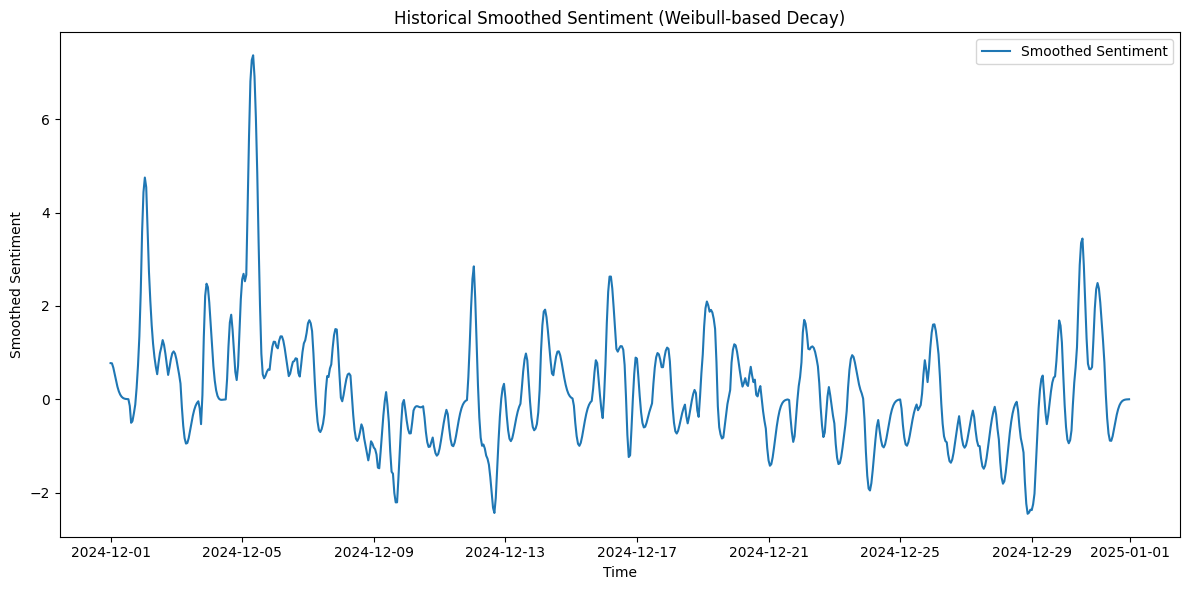

In [5]:
#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment_weibull'], label='Smoothed Sentiment')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#add the smoothed sentiment to the btc data (btc data is already hourly)
btc = pd.read_csv("../data/processed/btc_usdt_hourly_processed.csv")

btc['datetime'] = pd.to_datetime(btc['datetime'])
btc = btc.set_index('datetime')
btc = btc.join(df_sentiment)
btc = btc.dropna()
print(btc.head())

#add hourly post density from df to btc
df = df.set_index('created_at')
density = df.resample('H').size()
btc['post_density'] = density
#btc = btc.dropna()
print(btc.head())

                               OPEN      HIGH       LOW     CLOSE  \
datetime                                                            
2024-03-11 12:00:00+00:00  71487.20  72167.38  71304.20  71968.27   
2024-03-11 13:00:00+00:00  71968.27  72380.00  71336.00  71503.97   
2024-03-11 14:00:00+00:00  71503.97  72353.54  71492.00  72170.68   
2024-03-11 15:00:00+00:00  72170.68  72661.10  72000.00  72010.00   
2024-03-11 16:00:00+00:00  72010.00  72600.00  71795.29  72501.10   

                           TOTAL_TRADES  TOTAL_TRADES_BUY  TOTAL_TRADES_SELL  \
datetime                                                                       
2024-03-11 12:00:00+00:00        133689             69193              64496   
2024-03-11 13:00:00+00:00        191325             89262             102063   
2024-03-11 14:00:00+00:00        178891             82155              96736   
2024-03-11 15:00:00+00:00        165376             83206              82170   
2024-03-11 16:00:00+00:00        134

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_14496/267233479.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  density = df.resample('H').size()


In [9]:
#save data
btc.to_csv("../data/processed/btc_usdt_hourly_processed_with_sentiment.csv")